# 개, 고양이 분류(partial) - CNN v1
- 부분 데이터 : 훈련 dogs(1000), cats(1000), 테스트 dogs(1000), cats(1000)
- 이미지 센터링 처리 안함


In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
seed = 2022
np.random.seed(seed)
tf.random.set_seed(seed)

In [21]:
!wget https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip

In [22]:
!unzip cats_and_dogs_filtered.zip > /dev/null

- 데이터 탐색

In [23]:
train_dir = 'cats_and_dogs_filtered/train'
validation_dir = 'cats_and_dogs_filtered/validation'
train_cats_dir = 'cats_and_dogs_filtered/train/cats'
train_dogs_dir = 'cats_and_dogs_filtered/train/dogs'
validation_cats_dir = 'cats_and_dogs_filtered/validation/cats'
validation_dogs_dir = 'cats_and_dogs_filtered/validation/dogs'

In [24]:
# 파일 이름
import os 
train_cats_fnames = os.listdir(train_cats_dir)
train_dogs_fnames = os.listdir(train_dogs_dir)
print(train_cats_fnames[:5])
print(train_dogs_fnames[:5])

['cat.264.jpg', 'cat.708.jpg', 'cat.381.jpg', 'cat.37.jpg', 'cat.281.jpg']
['dog.28.jpg', 'dog.874.jpg', 'dog.140.jpg', 'dog.862.jpg', 'dog.290.jpg']


In [25]:
# 파일개수
len(train_cats_fnames)

1000

- 이미지 확인

In [26]:
fname = os.path.join(train_cats_dir, "cat.475.jpg")
fname

'cats_and_dogs_filtered/train/cats/cat.475.jpg'

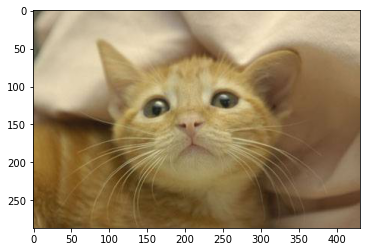

In [27]:
# 1) Pillow image
from PIL import Image
img = Image.open(fname)
plt.imshow(img)

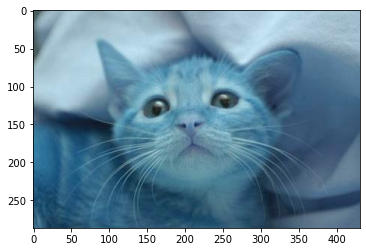

In [28]:
# 2) OpenCV image, 순서가 RGB가 아니라 BGR 로 읽음
import cv2
img2 = cv2.imread(fname)
plt.imshow(img2)

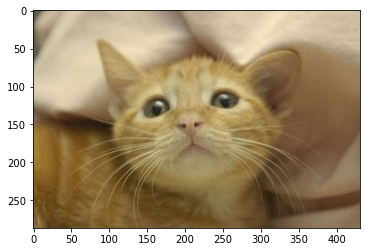

In [29]:
# OpenCV의 데이터는 numpy array
img3 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)  
plt.imshow(img3, )

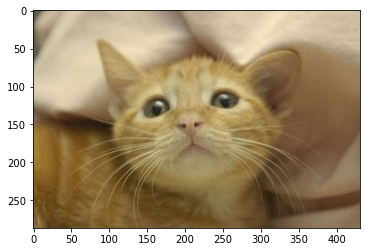

In [30]:
# OpenCV의 데이터는 numpy array
img2 = img2[:,:,::-1]   # rgb 순서 뒤바꾸는법
plt.imshow(img2)

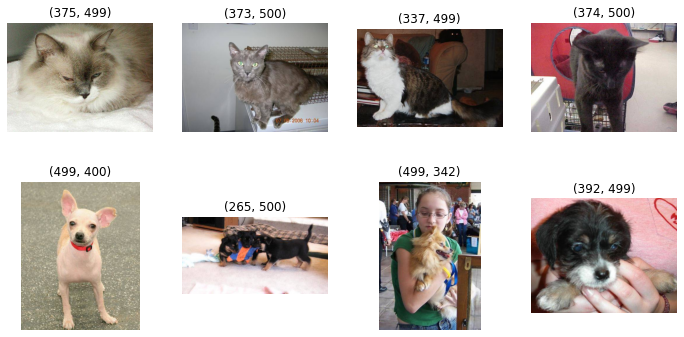

In [31]:
plt.figure(figsize = (12,6))
for i in range(1, 5):
    plt.subplot(2,4, i)
    cat = cv2.imread(os.path.join(train_cats_dir, train_cats_fnames[i]))[:,:,::-1]
    plt.imshow(cat), plt.axis("off"), plt.title(cat.shape[:-1])
    plt.subplot(2,4, i+4)
    dog = cv2.imread(os.path.join(train_dogs_dir, train_dogs_fnames[i]))[:,:,::-1]
    plt.imshow(dog), plt.axis("off"), plt.title(dog.shape[:-1])

- 모델 구성

In [32]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [33]:
model = Sequential([
        Conv2D(16, (3,3), input_shape = (150,150,3), activation = "relu"),
        MaxPooling2D(),
        Conv2D(32, (3,3), activation = "relu"),
        MaxPooling2D(),
        Conv2D(64, (3,3), activation = "relu"),
        MaxPooling2D(),
        Flatten(),
        Dense(512, activation = "relu"),
        # Dropout(0.25),
        Dense(1, activation = "sigmoid")
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 74, 74, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 17, 17, 64)      

In [34]:
from tensorflow.keras.optimizers import RMSprop
model.compile(optimizer=RMSprop(learning_rate=0.001, decay=1e-8), loss="binary_crossentropy", metrics = ["accuracy"])

In [35]:
model_path = "best-cats-and-dogs-cnn-v1.h5"
mc = ModelCheckpoint(model_path, save_best_only=True, verbose = 1)
es = EarlyStopping(patience = 10)

- 파일에서 이미지 데이터 읽어서 학습시키는 방법

In [36]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

In [37]:
train_generator = train_datagen.flow_from_directory(
    train_dir, batch_size = 20, class_mode = "binary", target_size = (150, 150)
)
test_generator = test_datagen.flow_from_directory(
    validation_dir, batch_size = 20, class_mode = "binary", target_size = (150, 150)
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


- 모델 실행

In [38]:
hist = model.fit(
    train_generator, validation_data = test_generator,
    epochs = 100, callbacks=[mc,es], 
    steps_per_epoch = 80, validation_steps = 50
)

Epoch 1/100
80/80 [==============================] - ETA: 0s - loss: 0.8110 - accuracy: 0.5663
Epoch 1: val_loss improved from inf to 0.63978, saving model to best-cats-and-dogs-cnn-v1.h5
80/80 [==============================] - 13s 126ms/step - loss: 0.8110 - accuracy: 0.5663 - val_loss: 0.6398 - val_accuracy: 0.6230
Epoch 2/100
80/80 [==============================] - ETA: 0s - loss: 0.6277 - accuracy: 0.6706
Epoch 2: val_loss did not improve from 0.63978
80/80 [==============================] - 8s 96ms/step - loss: 0.6277 - accuracy: 0.6706 - val_loss: 0.8850 - val_accuracy: 0.5780
Epoch 3/100
80/80 [==============================] - ETA: 0s - loss: 0.5751 - accuracy: 0.7069
Epoch 3: val_loss improved from 0.63978 to 0.61649, saving model to best-cats-and-dogs-cnn-v1.h5
80/80 [==============================] - 8s 97ms/step - loss: 0.5751 - accuracy: 0.7069 - val_loss: 0.6165 - val_accuracy: 0.6830
Epoch 4/100
80/80 [==============================] - ETA: 0s - loss: 0.5084 - accuracy

In [45]:
from google.colab import files 
up = files.upload()

Saving 개.jpg to 개 (1).jpg
Saving 개1.jfif to 개1 (1).jfif
Saving 개2.jpg to 개2 (1).jpg
Saving 고양이.jpg to 고양이 (1).jpg
Saving 고양이1.jpg to 고양이1 (1).jpg
Saving 고양이2.jfif to 고양이2 (1).jfif


(<matplotlib.image.AxesImage at 0x7f8d060c3510>, Text(0.5, 1.0, '(448, 680)'))

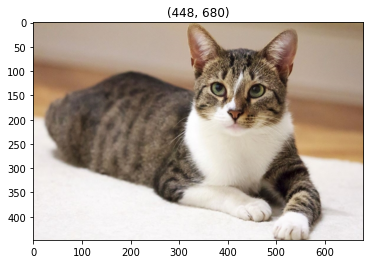

In [40]:
img = cv2.imread('고양이.jpg')[:,:,::-1]
plt.imshow(img), plt.title(img.shape[:-1],)

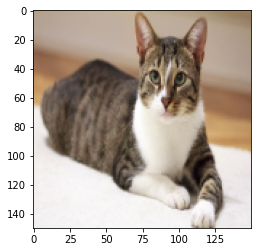

In [41]:
# 150 x 150
img = cv2.resize(img, dsize = (150,150), interpolation = cv2.INTER_AREA)
plt.imshow(img)

In [42]:
best_model = load_model("best-cats-and-dogs-cnn-v1.h5")

In [43]:
best_model.predict(img.reshape(1,150,150,3))

array([[1.]], dtype=float32)

In [46]:
for fname in up.keys():
    img = cv2.imread(fname)[:,:,::-1]
    if sum(img.shape[:-1]) > 300:
        img = cv2.resize(img, dsize = (150,150), interpolation = cv2.INTER_AREA)
    else:
        img = cv2.resize(img, dsize = (150,150), interpolation = cv2.INTER_CUBIC)
    classes = best_model.predict(img.reshape(1,150,150,3))
    print(f"{classes[0,0]:.4f} {fname} is a {'dog' if classes[0,0] > 0.5 else 'cat'}")

1.0000 개.jpg is a dog
1.0000 개1.jfif is a dog
0.0195 개2.jpg is a cat
1.0000 고양이.jpg is a dog
1.0000 고양이1.jpg is a dog
1.0000 고양이2.jfif is a dog
